# CIFAR10 with MLPs
Simple starter notebook to benchmark your own MLP with PyTorch on the CIFAR-10 dataset.

OBS.:

- The main code is basically done, so focus on training the models and searching for the best hyperparameters and architectures.
- You are not required to use this exact code or even the PyTorch library.
- It is recommended to use execution environments with GPU access (such as Google Colab), since larger models will take more time to train.
- Remember to document the history of your experiments and which results motivated the changes in subsequent experiments.

## Como tentamos melhorar o modelo:
- Utilizamos o optuna para encontrar melhores hiperparâmetros: learning rate, número de nós em cada camada e função de ativação
- Evitar overfiting:
    - Regularização com weight_decay no otimizador para diminuir a magnitude dos pesos
    - Uso de dropout para desativar 20% dos neurônios
    - separação do dataset de treinamento em treinamento e validação
    - Uso de early stopping levando em conta o loss da validação

In [52]:
%pip install optuna
%pip install torch
%pip install torchvision
%pip install scikit-learn
%pip install matplotlib
%pip install numpy
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [53]:
#@title Libs

import torch
from torch.utils.data import DataLoader

import torchvision
import torch.nn as nn
from torchvision import datasets, transforms

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Subset

import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

from tqdm import tqdm

import os
from collections import Counter

import optuna

# Data exploration

Quando usamos transforms.ToTensor(), a imagem (que antes era H x W x C) vira um tensor com shape: C x H x W

O matplotlib.pyplot.imshow() espera a imagem no formato H x W x C (como a maioria das bibliotecas de imagem em Python).


In [54]:
# Função para "desnormalizar" e mostrar imagens
def imshow(img):
    img = img / 2 + 0.5  # desfaz a normalização
    img = torch.clamp(img, 0, 1)  # limita os valores ao intervalo [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [109]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform= transform)

In [110]:
# Extraímos todos os rótulos do dataset de treino e ignoramos as imagens
labels = [label for _, label in dataset]

# Contamos quantas vezes cada rótulo aparece
label_counts = Counter(labels)

# Imprimimos o resultado com nome da classe
for class_idx, count in label_counts.items():
    class_name = dataset.classes[class_idx]
    print(f'{class_name}: {count} imagens')

frog: 5000 imagens
truck: 5000 imagens
deer: 5000 imagens
automobile: 5000 imagens
bird: 5000 imagens
horse: 5000 imagens
ship: 5000 imagens
cat: 5000 imagens
dog: 5000 imagens
airplane: 5000 imagens


In [111]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [112]:
def showImagesInLoader(loader):
    # Itera no loader e mostra imagens
    dataiter = iter(loader)
    images, labels = next(dataiter)

    # Mostra as imagens
    imshow(torchvision.utils.make_grid(images))

    # Mostra os rótulos correspondentes
    print(' '.join(f'{dataset.classes[label]}' for label in labels))

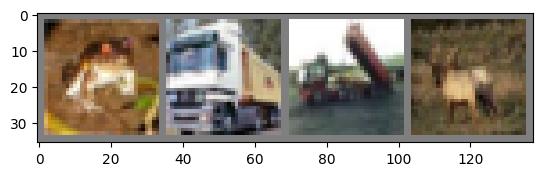

frog truck truck deer


In [113]:
loader = DataLoader(dataset, batch_size=4, shuffle=False)

showImagesInLoader(loader)

Scores of the first model:
  'accuracy': 0.474, 'balanced_accuracy': np.float64(0.47400000000000003), 'precision': 0.4788458695520801, 'recall': 0.474, 'f1_score': 0.4749641894435279



Adding Gaussinan Noise: 
Scores of your model
 {'accuracy': 0.529, 'balanced_accuracy': np.float64(0.5289999999999999), 'precision': 0.5276866099986426, 'recall': 0.529, 'f1_score': 0.5264172516467065}

Começamos a treinar uma mlp com 4 camadas usando imagens com 3 canais (RGB) , depois transformamos as imagens para a escala de cinza

In [60]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

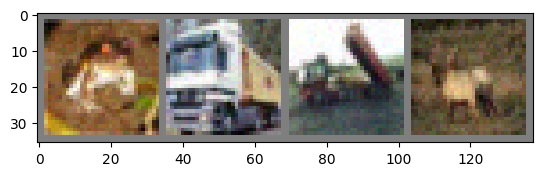

frog truck truck deer


In [114]:
#@title Dataset Setup

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    AddGaussianNoise(mean=0.0, std=0.05)
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

                                       # Itera no loader e mostra imagens
loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False)

showImagesInLoader(loader)


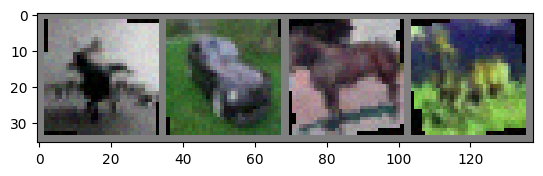

airplane automobile horse deer


In [148]:
# Definindo transformações de data augmentation com gaussian noise
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, shear=5), 
    transforms.RandomApply([transforms.RandomGrayscale(p=1.0)], p=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(1, 1), sigma=(0.1, 2.0))], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    AddGaussianNoise(mean=0.0, std=0.05)
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

augmented_loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)
showImagesInLoader(augmented_loader)

In [160]:
#@title Dataset Setup

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    AddGaussianNoise(mean=0.0, std=0.05)
])

train_val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


In [161]:
# Extrai os rótulos
targets = np.array(train_val_dataset.targets)

# Cria o validador estratificado
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Gera os índices
for train_idx, val_idx in splitter.split(np.zeros(len(targets)), targets):
    train_dataset = Subset(train_val_dataset, train_idx)
    val_dataset = Subset(train_val_dataset, val_idx)

In [162]:
# Acessa os rótulos (targets) do val_dataset
val_targets = [train_val_dataset[idx][1] for idx in val_dataset.indices]

# Conta quantas vezes cada classe aparece
val_distribution = Counter(val_targets)

print("Distribuição de classes no val_dataset:")
for label, count in sorted(val_distribution.items()):
    print(f"Classe {label}: {count} amostras")

Distribuição de classes no val_dataset:
Classe 0: 1000 amostras
Classe 1: 1000 amostras
Classe 2: 1000 amostras
Classe 3: 1000 amostras
Classe 4: 1000 amostras
Classe 5: 1000 amostras
Classe 6: 1000 amostras
Classe 7: 1000 amostras
Classe 8: 1000 amostras
Classe 9: 1000 amostras


In [163]:
#@title Loaders
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [164]:
#@title Defining the MLP model

class MLP(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, num_classes, activation_function):
        super(MLP, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_size, hidden1),
            activation_function,
            nn.Dropout(0.2),
            nn.Linear(hidden1, hidden2),
            activation_function,
            nn.Dropout(0.2),
            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.network(x)

## Hyperparameters Study



In [166]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

input_size = 32*32*3 # 32*32 RGB images 

def objective(trial):

    # Hiperparâmetros sugeridos pelo Optuna
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    hidden1 = trial.suggest_int("hidden1", 64, 256)
    hidden2 = trial.suggest_int("hidden2", 64, 256)
    activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "ELU"])

    activation_fn = getattr(nn, activation_name)()

    # Dataset e DataLoader (usa apenas um subset para acelerar)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    val_dataset, _ = torch.utils.data.random_split(train_dataset, [5000, len(train_dataset)-5000])
    train_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

    model = MLP(input_size,
                hidden1= hidden1,
                hidden2= hidden2,
                num_classes = 10,
                activation_function = activation_fn)

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Treinamento simples de 1-3 épocas (rápido)
    for epoch in range(3):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.view(-1, input_size).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    # Retorna a perda média como métrica a minimizar
    return running_loss / len(train_loader)

cuda


In [167]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2025-05-31 23:22:43,440] A new study created in memory with name: no-name-fc34062a-61e6-4ae9-9f8f-296454cad802
[I 2025-05-31 23:22:48,314] Trial 0 finished with value: 1.807344536238079 and parameters: {'lr': 0.0001628450931215813, 'hidden1': 118, 'hidden2': 250, 'activation': 'ReLU'}. Best is trial 0 with value: 1.807344536238079.
[I 2025-05-31 23:22:52,658] Trial 1 finished with value: 1.7463832806937303 and parameters: {'lr': 0.00022775550834556473, 'hidden1': 181, 'hidden2': 152, 'activation': 'LeakyReLU'}. Best is trial 1 with value: 1.7463832806937303.
[I 2025-05-31 23:22:56,774] Trial 2 finished with value: 2.0921438902239258 and parameters: {'lr': 2.9952288437778803e-05, 'hidden1': 94, 'hidden2': 244, 'activation': 'LeakyReLU'}. Best is trial 1 with value: 1.7463832806937303.
[I 2025-05-31 23:23:00,856] Trial 3 finished with value: 1.934250550934031 and parameters: {'lr': 9.154254428068276e-05, 'hidden1': 121, 'hidden2': 121, 'activation': 'ReLU'}. Best is trial 1 with value

In [168]:
print("Melhores hiperparâmetros:")
print(study.best_params)

Melhores hiperparâmetros:
{'lr': 0.001303357500064875, 'hidden1': 224, 'hidden2': 176, 'activation': 'ELU'}


In [169]:
#@title Hyperparameters
num_classes = 10

learning_rate = 0.0007
num_epochs = 30
hidden1 = 164
hidden2 = 188

activation_function = nn.ELU()

loss_function = nn.CrossEntropyLoss()

In [170]:
def evaluate(model, val_loader, loss_function):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.view(-1, input_size).to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
    model.train()
    return val_loss / len(val_loader)

In [171]:
#@title Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Build the model
mlp = MLP(input_size,
                hidden1= hidden1,
                hidden2= hidden2,
                num_classes = 10,
                activation_function = activation_function)
mlp.to(device)

# Setting optimizer up
optimizer = torch.optim.AdamW(mlp.parameters(), lr=learning_rate, weight_decay = 1e-4)

# Early stopping setup
best_loss = float('inf')
patience = 5
patience_counter = 0
best_model_state = None

train_losses = []
val_losses = []

# Start training epochs loop
for epoch in tqdm(range(num_epochs)):
  epoch_loss = 0.0
  for i, (images, labels) in enumerate(train_loader):
    images = images.view(-1,input_size).to(device) # flattenning images
    labels = labels.to(device)

    # Forward pass
    optimizer.zero_grad()
    outputs = mlp(images)

    # Backward pass
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

    if (i+1) % 1000 == 0:
      tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // batch_size}, Loss: {loss}')

  epoch_loss /= len(train_loader)
  tqdm.write(f'Epoch {epoch+1} average loss: {epoch_loss:.4f}')
  train_losses.append(epoch_loss)

  val_loss = evaluate(mlp, val_loader, loss_function)
  tqdm.write(f'Epoch {epoch+1} validation loss: {val_loss:.4f}')
  val_losses.append(val_loss)

  # Early stopping using loss value
  if val_loss < best_loss:
    best_loss = val_loss
    patience_counter = 0
    best_model_state = mlp.state_dict()
  else:
    patience_counter += 1
    if patience_counter >= patience:
      tqdm.write("Early stopping triggered.")
      break

if best_model_state is not None:
    mlp.load_state_dict(best_model_state)
    torch.save(mlp.state_dict(), "melhor_modelo.pth")


cuda


  0%|          | 0/30 [00:10<?, ?it/s]

 Epoch 1/30, Step 1000/2500, Loss: 2.1034328937530518


  0%|          | 0/30 [00:28<?, ?it/s]

 Epoch 1/30, Step 2000/2500, Loss: 1.6926900148391724


  0%|          | 0/30 [00:37<?, ?it/s]

Epoch 1 average loss: 1.7140


  3%|▎         | 1/30 [00:46<22:29, 46.54s/it]

Epoch 1 validation loss: 1.5550


  3%|▎         | 1/30 [01:04<22:29, 46.54s/it]

 Epoch 2/30, Step 1000/2500, Loss: 1.8296998739242554


  3%|▎         | 1/30 [01:22<22:29, 46.54s/it]

 Epoch 2/30, Step 2000/2500, Loss: 2.1345417499542236


  3%|▎         | 1/30 [01:30<22:29, 46.54s/it]

Epoch 2 average loss: 1.5493


  7%|▋         | 2/30 [01:34<22:03, 47.26s/it]

Epoch 2 validation loss: 1.4755


  7%|▋         | 2/30 [01:44<22:03, 47.26s/it]

 Epoch 3/30, Step 1000/2500, Loss: 1.8945624828338623


  7%|▋         | 2/30 [02:02<22:03, 47.26s/it]

 Epoch 3/30, Step 2000/2500, Loss: 1.8060202598571777


  7%|▋         | 2/30 [02:11<22:03, 47.26s/it]

Epoch 3 average loss: 1.4730


 10%|█         | 3/30 [02:19<20:49, 46.29s/it]

Epoch 3 validation loss: 1.4487


 10%|█         | 3/30 [02:32<20:49, 46.29s/it]

 Epoch 4/30, Step 1000/2500, Loss: 1.0379341840744019


 10%|█         | 3/30 [02:50<20:49, 46.29s/it]

 Epoch 4/30, Step 2000/2500, Loss: 1.3480435609817505


 10%|█         | 3/30 [02:59<20:49, 46.29s/it]

Epoch 4 average loss: 1.4189


 13%|█▎        | 4/30 [03:07<20:23, 47.05s/it]

Epoch 4 validation loss: 1.3957


 13%|█▎        | 4/30 [03:25<20:23, 47.05s/it]

 Epoch 5/30, Step 1000/2500, Loss: 1.4477136135101318


 13%|█▎        | 4/30 [03:43<20:23, 47.05s/it]

 Epoch 5/30, Step 2000/2500, Loss: 1.3338603973388672


 13%|█▎        | 4/30 [03:52<20:23, 47.05s/it]

Epoch 5 average loss: 1.3689


 17%|█▋        | 5/30 [04:01<20:33, 49.35s/it]

Epoch 5 validation loss: 1.4208


 17%|█▋        | 5/30 [04:19<20:33, 49.35s/it]

 Epoch 6/30, Step 1000/2500, Loss: 1.30569589138031


 17%|█▋        | 5/30 [04:32<20:33, 49.35s/it]

 Epoch 6/30, Step 2000/2500, Loss: 1.5072376728057861


 17%|█▋        | 5/30 [04:40<20:33, 49.35s/it]

Epoch 6 average loss: 1.3359


 20%|██        | 6/30 [04:49<19:37, 49.07s/it]

Epoch 6 validation loss: 1.3960


 20%|██        | 6/30 [05:07<19:37, 49.07s/it]

 Epoch 7/30, Step 1000/2500, Loss: 1.6004917621612549


 20%|██        | 6/30 [05:25<19:37, 49.07s/it]

 Epoch 7/30, Step 2000/2500, Loss: 1.540751338005066


 20%|██        | 6/30 [05:35<19:37, 49.07s/it]

Epoch 7 average loss: 1.3101


 23%|██▎       | 7/30 [05:43<19:26, 50.72s/it]

Epoch 7 validation loss: 1.3643


 23%|██▎       | 7/30 [06:01<19:26, 50.72s/it]

 Epoch 8/30, Step 1000/2500, Loss: 1.1528279781341553


 23%|██▎       | 7/30 [06:19<19:26, 50.72s/it]

 Epoch 8/30, Step 2000/2500, Loss: 1.121891736984253


 23%|██▎       | 7/30 [06:28<19:26, 50.72s/it]

Epoch 8 average loss: 1.2769


 27%|██▋       | 8/30 [06:36<18:51, 51.45s/it]

Epoch 8 validation loss: 1.3727


 27%|██▋       | 8/30 [06:54<18:51, 51.45s/it]

 Epoch 9/30, Step 1000/2500, Loss: 1.391653299331665


 27%|██▋       | 8/30 [07:12<18:51, 51.45s/it]

 Epoch 9/30, Step 2000/2500, Loss: 1.0485974550247192


 27%|██▋       | 8/30 [07:22<18:51, 51.45s/it]

Epoch 9 average loss: 1.2558


 30%|███       | 9/30 [07:30<18:15, 52.15s/it]

Epoch 9 validation loss: 1.3934


 30%|███       | 9/30 [07:48<18:15, 52.15s/it]

 Epoch 10/30, Step 1000/2500, Loss: 1.206312656402588


 30%|███       | 9/30 [08:05<18:15, 52.15s/it]

 Epoch 10/30, Step 2000/2500, Loss: 1.6473320722579956


 30%|███       | 9/30 [08:15<18:15, 52.15s/it]

Epoch 10 average loss: 1.2333


 33%|███▎      | 10/30 [08:23<17:28, 52.44s/it]

Epoch 10 validation loss: 1.3591


 33%|███▎      | 10/30 [08:41<17:28, 52.44s/it]

 Epoch 11/30, Step 1000/2500, Loss: 1.4296425580978394


 33%|███▎      | 10/30 [08:54<17:28, 52.44s/it]

 Epoch 11/30, Step 2000/2500, Loss: 1.1557228565216064


 33%|███▎      | 10/30 [09:03<17:28, 52.44s/it]

Epoch 11 average loss: 1.2150


 37%|███▋      | 11/30 [09:12<16:13, 51.26s/it]

Epoch 11 validation loss: 1.3705


 37%|███▋      | 11/30 [09:30<16:13, 51.26s/it]

 Epoch 12/30, Step 1000/2500, Loss: 1.0322191715240479


 37%|███▋      | 11/30 [09:47<16:13, 51.26s/it]

 Epoch 12/30, Step 2000/2500, Loss: 2.085726499557495


 37%|███▋      | 11/30 [09:57<16:13, 51.26s/it]

Epoch 12 average loss: 1.1959


 40%|████      | 12/30 [10:05<15:34, 51.94s/it]

Epoch 12 validation loss: 1.3562


 40%|████      | 12/30 [10:23<15:34, 51.94s/it]

 Epoch 13/30, Step 1000/2500, Loss: 1.2091304063796997


 40%|████      | 12/30 [10:41<15:34, 51.94s/it]

 Epoch 13/30, Step 2000/2500, Loss: 1.8735755681991577


 40%|████      | 12/30 [10:50<15:34, 51.94s/it]

Epoch 13 average loss: 1.1693


 43%|████▎     | 13/30 [10:56<14:40, 51.77s/it]

Epoch 13 validation loss: 1.3640


 43%|████▎     | 13/30 [11:06<14:40, 51.77s/it]

 Epoch 14/30, Step 1000/2500, Loss: 1.3565441370010376


 43%|████▎     | 13/30 [11:23<14:40, 51.77s/it]

 Epoch 14/30, Step 2000/2500, Loss: 1.330410122871399


 43%|████▎     | 13/30 [11:32<14:40, 51.77s/it]

Epoch 14 average loss: 1.1567


 47%|████▋     | 14/30 [11:40<13:10, 49.38s/it]

Epoch 14 validation loss: 1.3590


 47%|████▋     | 14/30 [11:58<13:10, 49.38s/it]

 Epoch 15/30, Step 1000/2500, Loss: 0.6992118954658508


 47%|████▋     | 14/30 [12:16<13:10, 49.38s/it]

 Epoch 15/30, Step 2000/2500, Loss: 1.0569181442260742


 47%|████▋     | 14/30 [12:25<13:10, 49.38s/it]

Epoch 15 average loss: 1.1417


 50%|█████     | 15/30 [12:34<12:39, 50.63s/it]

Epoch 15 validation loss: 1.3645


 50%|█████     | 15/30 [12:52<12:39, 50.63s/it]

 Epoch 16/30, Step 1000/2500, Loss: 1.634013295173645


 50%|█████     | 15/30 [13:01<12:39, 50.63s/it]

 Epoch 16/30, Step 2000/2500, Loss: 1.1673626899719238


 50%|█████     | 15/30 [13:05<12:39, 50.63s/it]

Epoch 16 average loss: 1.1303


 53%|█████▎    | 16/30 [13:09<10:42, 45.91s/it]

Epoch 16 validation loss: 1.3752


 53%|█████▎    | 16/30 [13:18<10:42, 45.91s/it]

 Epoch 17/30, Step 1000/2500, Loss: 1.0170539617538452


 53%|█████▎    | 16/30 [13:26<10:42, 45.91s/it]

 Epoch 17/30, Step 2000/2500, Loss: 0.7868446111679077


 53%|█████▎    | 16/30 [13:31<10:42, 45.91s/it]

Epoch 17 average loss: 1.1144


 57%|█████▋    | 17/30 [13:34<08:36, 39.74s/it]

Epoch 17 validation loss: 1.3464


 57%|█████▋    | 17/30 [13:43<08:36, 39.74s/it]

 Epoch 18/30, Step 1000/2500, Loss: 0.7162991762161255


 57%|█████▋    | 17/30 [13:52<08:36, 39.74s/it]

 Epoch 18/30, Step 2000/2500, Loss: 1.2571913003921509


 57%|█████▋    | 17/30 [13:56<08:36, 39.74s/it]

Epoch 18 average loss: 1.1014


 60%|██████    | 18/30 [13:59<07:04, 35.37s/it]

Epoch 18 validation loss: 1.3672


 60%|██████    | 18/30 [14:07<07:04, 35.37s/it]

 Epoch 19/30, Step 1000/2500, Loss: 1.3315767049789429


 60%|██████    | 18/30 [14:15<07:04, 35.37s/it]

 Epoch 19/30, Step 2000/2500, Loss: 0.7954974174499512


 60%|██████    | 18/30 [14:18<07:04, 35.37s/it]

Epoch 19 average loss: 1.0908


 63%|██████▎   | 19/30 [14:22<05:46, 31.51s/it]

Epoch 19 validation loss: 1.3695


 63%|██████▎   | 19/30 [14:31<05:46, 31.51s/it]

 Epoch 20/30, Step 1000/2500, Loss: 1.6794394254684448


 63%|██████▎   | 19/30 [14:39<05:46, 31.51s/it]

 Epoch 20/30, Step 2000/2500, Loss: 1.1581964492797852


 63%|██████▎   | 19/30 [14:44<05:46, 31.51s/it]

Epoch 20 average loss: 1.0755


 67%|██████▋   | 20/30 [14:48<04:58, 29.84s/it]

Epoch 20 validation loss: 1.3776


 67%|██████▋   | 20/30 [15:05<04:58, 29.84s/it]

 Epoch 21/30, Step 1000/2500, Loss: 1.077221393585205


 67%|██████▋   | 20/30 [15:23<04:58, 29.84s/it]

 Epoch 21/30, Step 2000/2500, Loss: 1.1240299940109253


 67%|██████▋   | 20/30 [15:31<04:58, 29.84s/it]

Epoch 21 average loss: 1.0673


 70%|███████   | 21/30 [15:35<05:15, 35.11s/it]

Epoch 21 validation loss: 1.3566


 70%|███████   | 21/30 [15:45<05:15, 35.11s/it]

 Epoch 22/30, Step 1000/2500, Loss: 1.250174641609192


 70%|███████   | 21/30 [15:54<05:15, 35.11s/it]

 Epoch 22/30, Step 2000/2500, Loss: 0.6288266181945801


 70%|███████   | 21/30 [15:58<05:15, 35.11s/it]

Epoch 22 average loss: 1.0516


 70%|███████   | 21/30 [16:03<06:52, 45.87s/it]

Epoch 22 validation loss: 1.3897
Early stopping triggered.


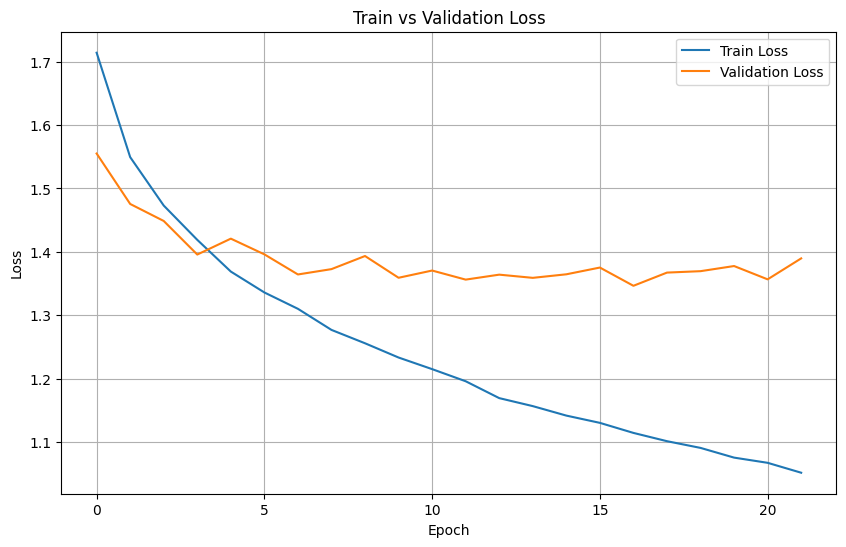

In [173]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [174]:
print(device)

cuda


In [175]:
#@title Defining metrics helper

def get_scores(targets, predictions):
    return {
        "accuracy": metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "precision": metrics.precision_score(targets, predictions, average="weighted"),
        "recall": metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score": metrics.f1_score(targets, predictions, average="weighted")
    }

In [176]:
#@title Evaluate model (accuracy, precision, recall)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

mlp = MLP(input_size,
          hidden1= hidden1,
          hidden2= hidden2,
          num_classes = 10,
          activation_function = activation_function)

mlp.to(device)

if os.path.exists("melhor_modelo.pth"):
    mlp.load_state_dict(torch.load("melhor_modelo.pth"))
    print("Pesos carregados com sucesso.")
else:
    print("Arquivo de pesos não encontrado. Modelo será inicializado do zero.")

mlp.eval()
predictions = []
labels = []
for images, label in val_loader:
  images = images.view(-1,input_size).to(device)
  label = label.to(device)

  output = mlp(images)
  _, predicted = torch.max(output,1)

  predictions.extend(predicted.cpu().numpy())
  labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

cuda
Pesos carregados com sucesso.
Scores of your model
 {'accuracy': 0.5352, 'balanced_accuracy': np.float64(0.5352), 'precision': 0.5379579079526892, 'recall': 0.5352, 'f1_score': 0.5333237077149121}


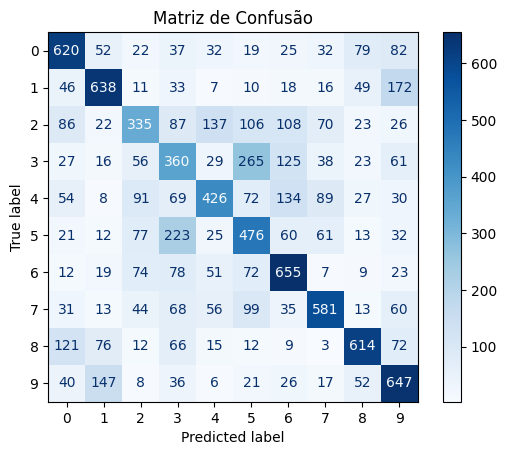

In [177]:
cm = confusion_matrix(labels, predictions)

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)  # pode mudar o colormap se quiser
plt.title("Matriz de Confusão")
plt.show()

In [136]:
for label in range(10):
    print(f"{label}: {test_dataset.classes[label]}")

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92526716..1.0537698].


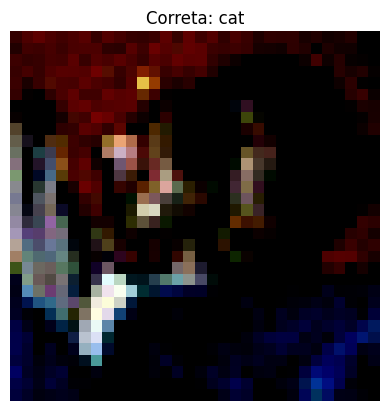

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1052287..1.0334064].


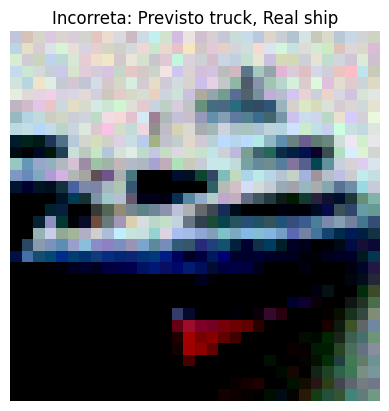

In [178]:
# Lista com nomes das classes (exemplo para CIFAR-10)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Detecta o dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move o modelo para o dispositivo
mlp.to(device)
mlp.eval()

correct_image = None
incorrect_image = None

# Sem gradientes para avaliação
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = mlp(images)
        _, preds = torch.max(outputs, 1)

        for i in range(len(labels)):
            if preds[i] == labels[i] and correct_image is None:
                correct_image = images[i].cpu()
                correct_label = labels[i].cpu()
                predicted_correct = preds[i].cpu()
            elif preds[i] != labels[i] and incorrect_image is None:
                incorrect_image = images[i].cpu()
                true_label = labels[i].cpu()
                predicted_incorrect = preds[i].cpu()

            if correct_image is not None and incorrect_image is not None:
                break
        if correct_image is not None and incorrect_image is not None:
            break

# Função para exibir imagem
def show_image(img_tensor, title=""):
    img = img_tensor.permute(1, 2, 0)  # de (C, H, W) para (H, W, C)
    plt.imshow(img.numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

# Mostra imagens com nomes das classes
show_image(correct_image, f"Correta: {class_names[predicted_correct.item()]}")
show_image(incorrect_image, f"Incorreta: Previsto {class_names[predicted_incorrect.item()]}, Real {class_names[true_label.item()]}")


# You can change/optimize this as you want
- Different optimizers, activation functions, etc
- Automatic hyperparameters optimization (Optuna)
- Regularization techniques
- Validation set to track metrics during epochs
- Transform input data
- ...